In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [25]:
ts = pd.read_csv('./content/Electric_Production.csv', 
                 header=0, index_col=0, parse_dates=True)
ts.head()

,Utilities
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [26]:
ts.shape

(397, 1)

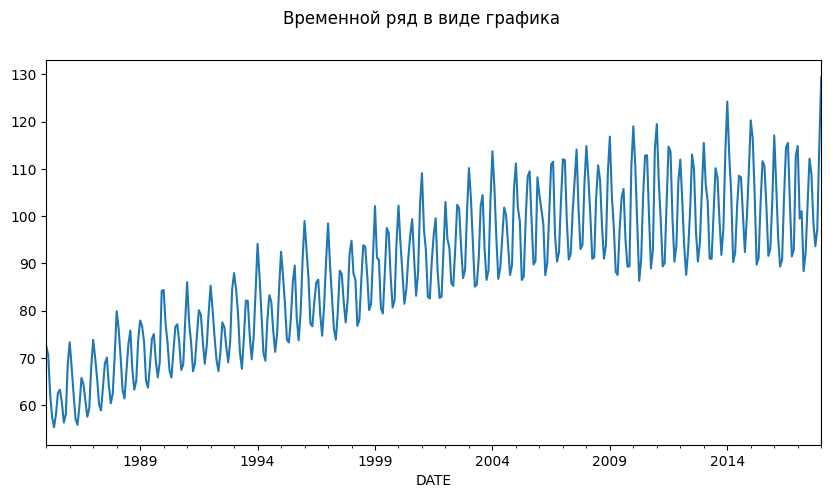

In [27]:
# визуализация
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
ts.plot(ax=ax, legend=False)
pyplot.show()

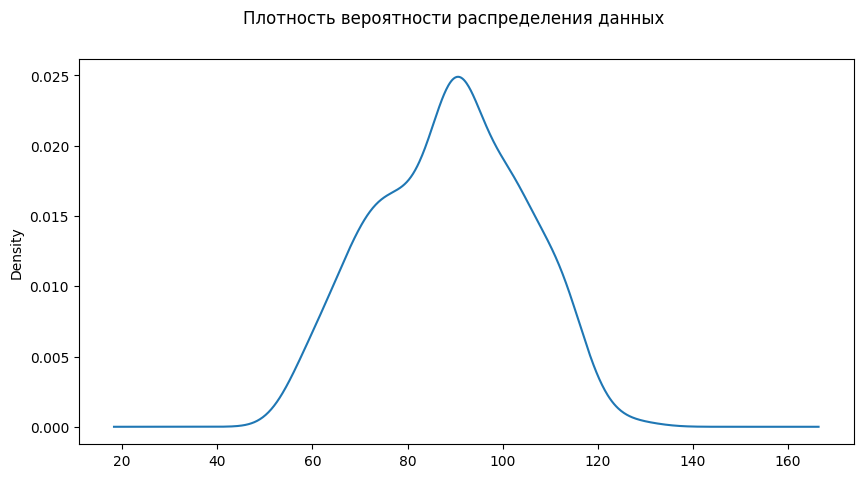

In [29]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
ts.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

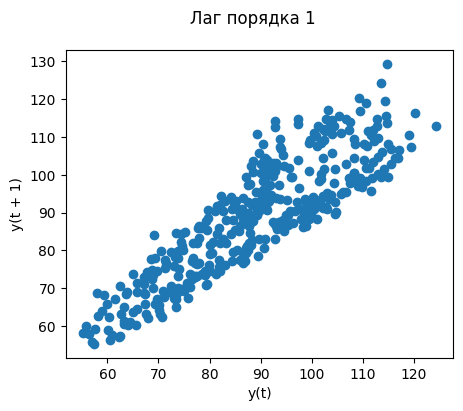

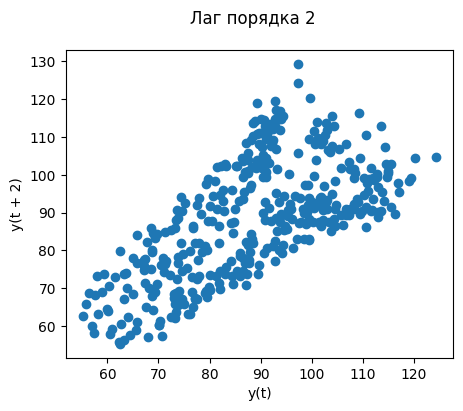

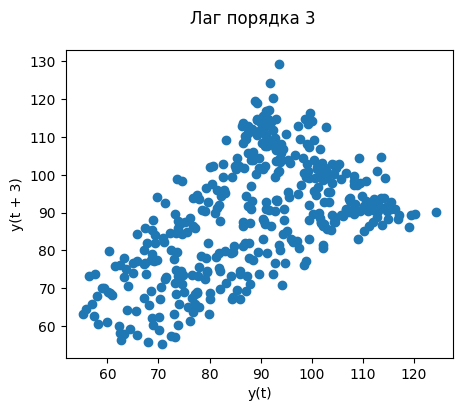

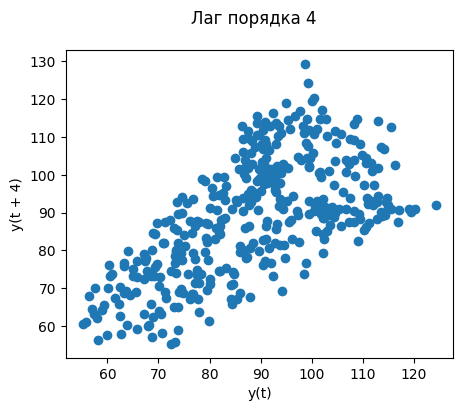

In [30]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(ts, lag=i, ax=ax)
    pyplot.show()

In [31]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data, model='add'):
    result_add = seasonal_decompose(data, model = 'add')
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()
    
# Тренд - это тенденция, направление временного ряда.
# Сезонность показывает влияние периодичности (день недели, время года и т.д.), 
# фактически определяет "колебание" временного ряда вокруг тренда.
# Шум - это случайная составляющая ряда.

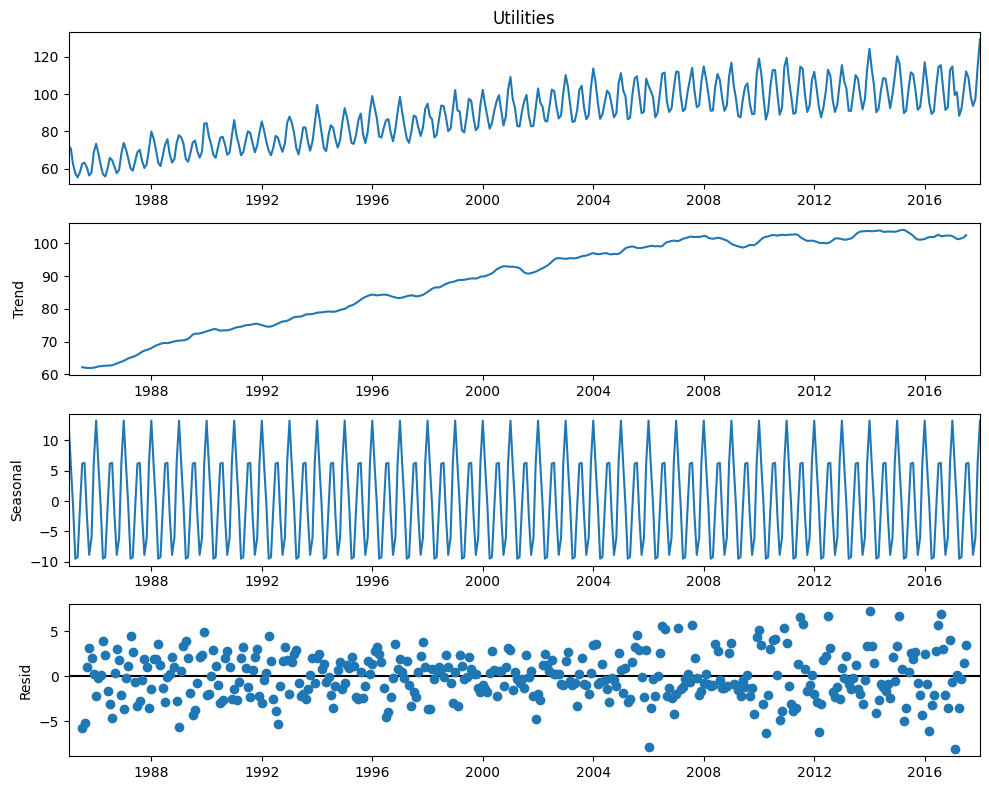

In [32]:
plot_decompose(data=ts[ts.columns[0]], model='add')

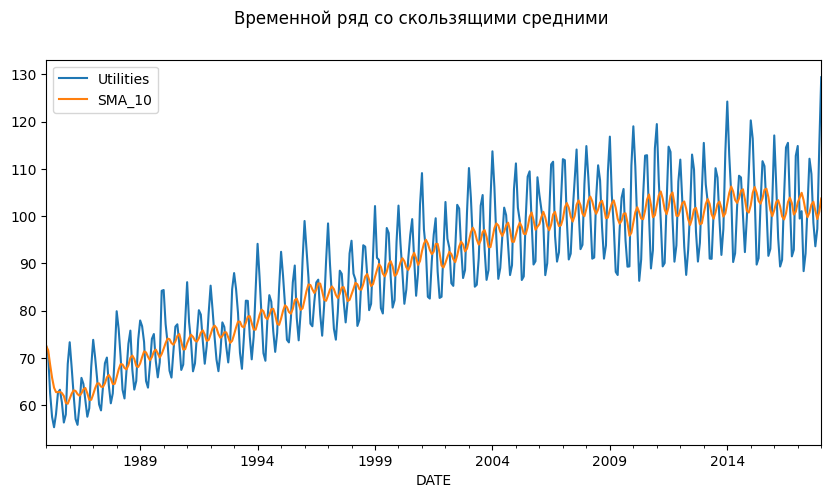

In [33]:
ts_copy = ts.copy()
# Простое скользящее среднее (SMA)
ts['SMA_10'] = ts[ts.columns[0]].rolling(10, min_periods=1).mean()
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
ts.plot(ax=ax, legend=True)
pyplot.show()

In [34]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Целочисленная метка шкалы времени 
xnum = list(range(ts.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = ts[ts.columns[0]].values
train_size = int(len(Y) * 0.8)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [35]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [36]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [37]:
# %%cache 
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts_copy.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=356.504
ARIMA(0, 0, 1) MSE=129.351
ARIMA(0, 0, 2) MSE=71.079
ARIMA(0, 1, 0) MSE=88.890
ARIMA(0, 1, 1) MSE=63.224
ARIMA(0, 1, 2) MSE=50.669
ARIMA(0, 2, 0) MSE=107.675
ARIMA(0, 2, 1) MSE=102.587
ARIMA(0, 2, 2) MSE=63.393
ARIMA(1, 0, 0) MSE=85.341
ARIMA(1, 0, 1) MSE=58.158
ARIMA(1, 0, 2) MSE=50.805
ARIMA(1, 1, 0) MSE=75.646
ARIMA(1, 1, 1) MSE=63.114
ARIMA(1, 1, 2) MSE=46.348
ARIMA(1, 2, 0) MSE=105.163
ARIMA(1, 2, 1) MSE=78.330
ARIMA(1, 2, 2) MSE=63.267
ARIMA(2, 0, 0) MSE=66.162
ARIMA(2, 0, 1) MSE=55.998
ARIMA(2, 0, 2) MSE=46.403
ARIMA(2, 1, 0) MSE=40.037
ARIMA(2, 1, 1) MSE=21.678
ARIMA(2, 1, 2) MSE=15.041
ARIMA(2, 2, 0) MSE=89.330
ARIMA(2, 2, 1) MSE=40.141
ARIMA(3, 0, 0) MSE=39.426
ARIMA(3, 0, 1) MSE=21.728
ARIMA(3, 0, 2) MSE=20.584
ARIMA(3, 1, 0) MSE=25.156
ARIMA(3, 1, 1) MSE=20.320
ARIMA(3, 1, 2) MSE=14.722
ARIMA(3, 2, 0) MSE=58.410
ARIMA(3, 2, 1) MSE=25.216
ARIMA(3, 2, 2) MSE=20.854
ARIMA(4, 0, 0) MSE=25.247
ARIMA(4, 0, 1) MSE=20.384
ARIMA(4, 0, 2) MSE=21.155
ARIMA(4

In [38]:
# Параметры модели (p,d,q) p q d — целые числа, задающие порядок модели, d=0 -> ARMA
arima_order = (10,1,2)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [39]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

# Ошибка прогноза
np.mean(Y), error_arima, error_es

(88.84721763224182, 3.779722589752616, 9.50603515563499)

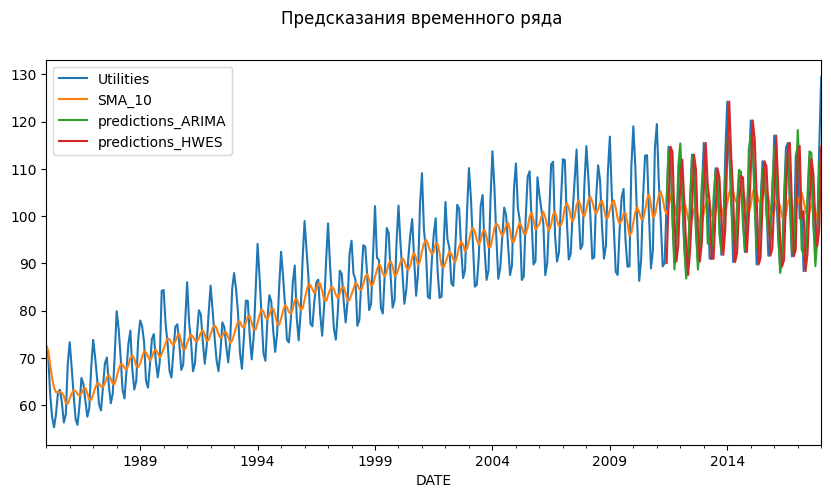

In [40]:
# Записываем предсказания в DataFrame
ts['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
ts['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
ts.plot(ax=ax, legend=True)
pyplot.show()

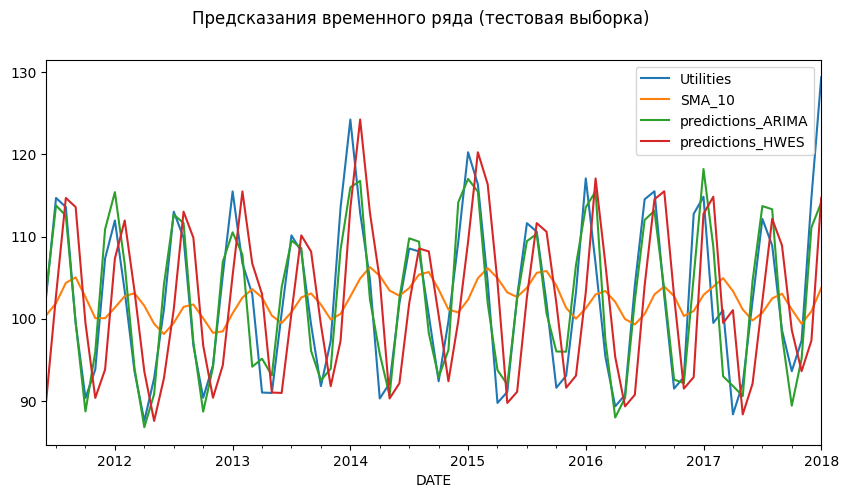

In [41]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
ts[train_size:].plot(ax=ax, legend=True)
pyplot.show()